# Amazon Review Polarity/ Sentiment Classification

#### Installing Dependency

In [2]:
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_lg
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 12.8MB 378kB/s 
     |████████████████████████████████| 460kB 47.5MB/s 
     |████████████████████████████████| 1.1MB 49.0MB/s 
     |████████████████████████████████| 9.1MB 52.1MB/s 
     |████████████████████████████████| 122kB 49.8MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=b059d2e647ea80396530dc4d5e87fc7e2f1ce06688cc555ed5a06f2b7fd0be10
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: smart-open 4.2.0
    Uninstallin

In [11]:
import os
import re
import tqdm 
import string 
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import csv
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from googletrans import Translator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

# text preprocessing
from nltk.tokenize import word_tokenize
import pkg_resources
import re, string, json
import spacy
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))
SEED = 78

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## DATA EXPLORATORY & CLEANING

Objective is to make the data as error-free as possible for the model to train on.
- explore the data, print out the statistics to understand the dataset composition
- Identify characters that do not contain information and does not facilitate in model training 
<br>(e.g. foreign language, special symbols, special character, wrong punctuation, werid numbers, wrong spelling)
- Remove or fill empty rows with default values
- convert the dataset to lower- cased. 

In [14]:
#reading data from custom csv file
review_df = pd.read_csv('review_table_new.csv', engine='python')

#print out the stats of the dataset 
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11104 entries, 0 to 11103
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            11104 non-null  int64  
 1   product_id       11104 non-null  object 
 2   product          11104 non-null  object 
 3   generic_product  11104 non-null  object 
 4   uname            11102 non-null  object 
 5   rating           11104 non-null  float64
 6   review_title     11103 non-null  object 
 7   review           11104 non-null  object 
 8   date             11104 non-null  object 
 9   image            1646 non-null   object 
 10  upvotes          11104 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 954.4+ KB


In [15]:
#visualise how the dataset looks like
review_df[15:20]

,index,product_id,product,generic_product,uname,rating,review_title,review,date,image,upvotes
15,15,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,C. Stucky,2.0,What did I even buy?,I ordered this the day before yesterday. I was...,2021-02-18T00:00:00,https://images-na.ssl-images-amazon.com/images...,12
16,16,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Musicfan,2.0,A painful process to return the phone,Update: Samsung finally issued a return author...,2021-02-20T00:00:00,NaN,19
17,17,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,araknid_y,1.0,Serious downgrade,I thought I was trading up from S8 to S21 but ...,2021-02-28T00:00:00,NaN,14
18,18,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Muscle428,5.0,Happy Wife,Got it for my Wife. She loves it,2021-04-05T00:00:00,NaN,0
19,19,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Susana de jesus,5.0,Excelente Amazon. Y excelente precio..,Me encantó el teléfono apenas lo estoy configu...,2021-02-17T00:00:00,NaN,12


## Categorize data as "neutral" versus "opinionated"

As we are doing sentiment analysis, we have to label our data to classify positive and negative sentiments.

In our rating column, we have ratings from 1 to 5. We can define 1 and 2 as bad reviews and 4 and 5 as good review.

A rating of 3 would be consider neither good nor bad. Hence, we decided to ger rid of all the rating 3 as they are considered as neutral in our categorisation process.

'label': either 2 (positive) or 1 (negative) rating.

In [16]:
def polarity_labelling(value):
  # create a column to label the data as positive or negative base on ratings
  return 2 if value >= 4 else 1


def categorize_data(dataframe):

  #remove rating '3' from the dataframe
  dataframe = dataframe[dataframe['rating'] != 3]

  #creating a new label from ratings
  dataframe['label'] = dataframe['rating'].apply(polarity_labelling)

  dataframe['content'] = dataframe['review_title']+ ".\n " +dataframe['review']

  #extract necessary columns from dataframe
  dataframe = dataframe.loc[:,['product_id', 'generic_product', 'content', 'label']]
  
  #drop empty rows if elements are missing in 'content' column
  dataframe =dataframe.dropna(subset=['content'])

  #drop duplicates from dataframe of elements are missing in 'content' column
  dataframe.drop_duplicates(subset=['content'])

  #resetting index
  dataframe.reset_index(drop=True, inplace=True)
  
  return dataframe

In [17]:
cleaned_review_df = categorize_data(review_df)
cleaned_review_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(10139, 4)

In [18]:
cleaned_review_df

,product_id,generic_product,content,label
0,B08N2FRMPN,Smartphone,Phone come without charger....Interesting.\n T...,1
1,B08N2FRMPN,Smartphone,"Top Notch.\n Fast Delivery,\nSamsung really do...",2
2,B08N2FRMPN,Smartphone,Excellent phone and price combo.\n Pros:\nSnap...,2
3,B08N2FRMPN,Smartphone,Perfect upgrade.\n Great upgrade. Battery is r...,2
4,B08N2FRMPN,Smartphone,Very happy with the S21.\n Perfect little phone.,2
...,...,...,...,...
10134,B07P85CDHG,Speaker,Disappointing audio quality.\n While there are...,1
10135,B07P85CDHG,Speaker,Sony SRS-XB12 Speakers.\n This is my third set...,2
10136,B07P85CDHG,Speaker,Great sound in a small package!.\n Absolutely ...,2
10137,B07P85CDHG,Speaker,Pretty great!.\n This little guy is pretty gre...,2


### Data Imbalance

We first plot general distribution of the product, as we can see the dataset is is generally balanced across the product categories. However, on further inspection of the positive and negative sentiment accross each cateogory, we can see than the data has more postive sentimennts than negative. By plotting distribution of postive and negaitve sentiment, we can see it is true.


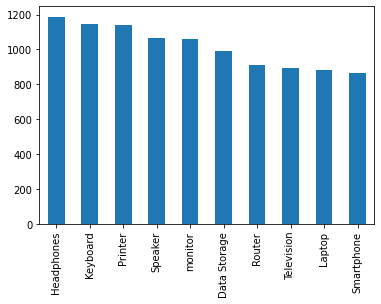

In [19]:
#get general distribution of product 
product_distribution = cleaned_review_df.generic_product.value_counts()
product_distribution.plot.bar()

In [20]:
product_distribution.to_frame()

,generic_product
Headphones,1187
Keyboard,1146
Printer,1140
Speaker,1064
monitor,1058
Data Storage,990
Router,913
Television,891
Laptop,884
Smartphone,866


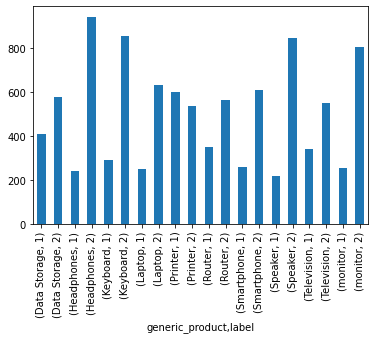

In [21]:
product_label_distribution = cleaned_review_df.groupby(['generic_product', 'label']).size()
product_label_distribution.plot.bar()

In [22]:
product_label_distribution.to_frame()

0
generic_product label     
Data Storage    1      411
                2      579
Headphones      1      242
                2      945
Keyboard        1      290
                2      856
Laptop          1      250
                2      634
Printer         1      602
                2      538
Router          1      350
                2      563
Smartphone      1      257
                2      609
Speaker         1      219
                2      845
Television      1      341
                2      550
monitor         1      253
                2      805

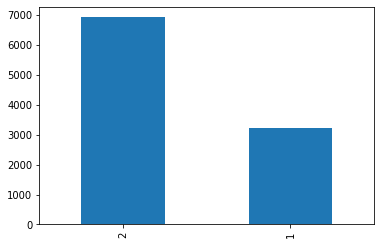

In [23]:
label_distribution = cleaned_review_df.label.value_counts()
label_distribution.plot.bar()

In [24]:
label_distribution.to_frame()

,label
2,6924
1,3215


# Solving Data Imbalance

To manage the issue of data imbalance, we will be using padding additonal data on top of the exisiting crawled Amazon review. The data is from Amazon Polarity Review Dataset (https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz). 

The Amazon reviews dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review.

Xiang Zhang (xiang.zhang@nyu.edu) constructed the Amazon reviews polarity dataset based on the Amazon reviews dataset by taking review score 1 and 2 as negative, and 4 and 5 as positive. Samples of score 3 is ignored. In the dataset, class 1 is the negative and class 2 is the positive. Each class has 1,800,000 training samples and 200,000 testing samples.


**Data Fields**
<br> **title**:
<br> A string containing the title of the review - escaped using double quotes (") and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

<br>**content**:
<br> a string containing the body of the document - escaped using double quotes (") and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

<br>**label**: 
<br> either 2 (positive) or 1 (negative) rating.


# Managing dataset

We will be predicting the polarity of aprpoximately 9,000 review from our custom review dataset which will then be used for indexing and querying for our recommendation system.

Since we have 10,139 records from our review dataset. We will be extracting 90% for test (aprrox ~9,000 records) and the remaining 10% (~1000 records) will be combined with Amazon Polarity Review Dataset. This will be done via stratifed train_test_split w.r.t "generic_product" and "label".

To a train, validation, and test ratio of 70%, 15% and 15%. We will stratify sample 48,158 from Amazon Polarity Review Dataset and combined with the crawled 2,535 records. The combined record will then be split into train and validation Dataset.

In [25]:
!wget --no-check-certificate \
    'https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz' \
    -O './amazon_review_polarity_csv.tgz'

!tar -xzvf './amazon_review_polarity_csv.tgz'

--2021-04-11 13:29:56--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.195.160
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.195.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘./amazon_review_polarity_csv.tgz’

./amazon_review_pol 100%[===================>] 656.45M  67.5MB/s    in 11s     

2021-04-11 13:30:07 (60.6 MB/s) - ‘./amazon_review_polarity_csv.tgz’ saved [688339454/688339454]

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


In [26]:
amazon_dataset = pd.read_csv('amazon_review_polarity_csv/train.csv', header=None)
amazon_dataset.columns = ['label', 'review_title', 'review']
print(f'Train shape: {amazon_dataset.shape}')

Train shape: (3600000, 3)


In [27]:
amazon_dataset.head()

,label,review_title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [28]:
def format_data(dataframe):

  if 'content' not in dataframe.columns:
    dataframe['content'] = dataframe['review_title']+ ".\n " +dataframe['review']

  #extract necessary columns from dataframe
  dataframe = dataframe.loc[:,['content', 'label']]
  
  #drop empty rows if elements are missing in 'content' column
  dataframe =dataframe.dropna(subset=['content'])

  #drop duplicates from dataframe of elements are missing in 'content' column
  dataframe.drop_duplicates(subset=['content'])

  #reset index
  dataframe.reset_index(drop=True, inplace=True)
  
  return dataframe

In [29]:
def data_split(custom_df, amazon_polarity_df, seed):

  # Spliting the custom dataset into 10% train and 90% test
  custom_train, custom_test = train_test_split(custom_df,  test_size=0.9, shuffle= seed, stratify= custom_df[['generic_product', 'label']])

  #formating dataframe to show only content & label
  custom_train = format_data(custom_train)
  amazon_polarity_df = format_data(amazon_polarity_df)

  amazon_polarity_df1 = amazon_polarity_df[amazon_polarity_df['label'] == 1]
  amazon_polarity_df2 = amazon_polarity_df[amazon_polarity_df['label'] == 2]
  
  #extracting 50,000 samples from the amazon_polarity_dataset
  amazon_polarity_df1 = amazon_polarity_df1.sample(n= 15000, random_state = seed)
  amazon_polarity_df2 = amazon_polarity_df2.sample(n= 15000, random_state = seed)

  #combining datasets together

  combined_train = pd.concat([amazon_polarity_df1 , amazon_polarity_df2 , custom_train])

  combined_train = format_data(combined_train)

  #reset index
  custom_test.reset_index(drop=True, inplace=True)
  
  return combined_train , custom_test 


In [30]:
combined_data, test_data = data_split(custom_df= cleaned_review_df, amazon_polarity_df= amazon_dataset, seed= 10)  

In [31]:
combined_data.shape

(31013, 2)

In [32]:
test_data.shape

(9126, 4)

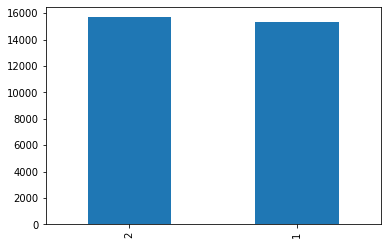

In [33]:
combined_label = combined_data.label.value_counts()
combined_label.plot.bar()

In [34]:
combined_label.to_frame()

,label
2,15692
1,15321


In [35]:
combined_data

,content,label
0,Advertising.\n This is basically a feel-good b...,1
1,"Cant Read BluRay.\n Unfortunately, unable to p...",1
2,Good while it lasted...for a minute.\n This TV...,1
3,Didn't get the movie only an empty case..\n I ...,1
4,No BluRay in case.\n I bought this to watch wi...,1
...,...,...
31008,A challenge to get at.\n No complaints about t...,1
31009,Je recommande.\n Très facile à installer à l’a...,2
31010,Did the job !!!!.\n It freed up space for my l...,2
31011,Best bang for your buck.\n This monitor replac...,2


In [36]:
test_data

,product_id,generic_product,content,label
0,B01C3H9FGM,Headphones,Terrific commuter headphones.\n I take the bus...,2
1,B00NJ2M33I,Headphones,"By Far The Most Comfortable, Especially With G...",2
2,B078X1DQ2Y,Printer,"Good printer.\n Set it up, works great. I need...",2
3,B07TSMX36P,Speaker,Good product so far. But small issues..\n Good...,2
4,B01M0GB8CC,Headphones,GOT GROSS USED BROKEN EARPHONES.\n opened the ...,1
...,...,...,...,...
9121,B08H2H89K1,Laptop,Affordable gaming computer. Great for The Sims...,2
9122,B08KTWXCZT,Router,Solid router and very good performance.\n Disc...,2
9123,B078X1DQ2Y,Printer,Excellent Printer.\n My more expensive Canon P...,2
9124,B01CQOV3YO,Speaker,This is a great speaker for the price!.\n This...,2


## Data Proprocessing

### Method 1 - Traditional Text Preprocessing Framework

  1.  Tokenization

Tokenization is a step which splits longer strings of text into smaller pieces, or tokens. Larger chunks of text can be tokenized into sentences, sentences can be tokenized into words, etc.

  2.  Normalization

Before further processing, text needs to be normalized. Normalization generally refers to a series of related tasks meant to put all text on a level playing field: converting all text to the same case (upper or lower), removing punctuation, converting numbers to their word equivalents, and so on. Normalization puts all words on equal footing, and allows processing to proceed uniformly. 

3.  Lemmatization

Lemmatization is related to stemming, differing in that lemmatization is able to capture canonical forms based on a word's lemma.

#### My Pre-processing Pipeline
- Language Translation (since some of the reviews are in spanish)
- Tokenization 
- Stopword removal

Normalization task
- convert emoji to words (since some of the reviews have emoji)
- URL removal
- puncuation removal 
- spelling correction
- abbervation ( converting internet slang)


 Implementating Peter Norvig's Spell Correction Algorithm using Word2vec for spelling correction

In [37]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" \
    -O './GoogleNews-vectors-negative300.bin.gz'


--2021-04-11 13:30:55--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘./GoogleNews-vectors-negative300.bin.gz’

./GoogleNews-vector 100%[===================>]   1.53G  84.5MB/s    in 20s     

2021-04-11 13:31:16 (76.7 MB/s) - ‘./GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [38]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',  binary=True)


words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [39]:
import re
import collections
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

Implementing Emoji replacement using custom emoji pickle file

In [40]:
import pickle
import re

with open('Emoji_Dict.p', 'rb') as fp:
  Emoji_Dict = pickle.load(fp)

Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

#convert emojis to words
def convert_emojis_to_word(text):
  for emot in Emoji_Dict:
    text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
  return text

Implementing foreign language translation using Google Translate Api

In [41]:
from googletrans import Translator

translator = Translator()


#translate foreign language to English
def translate(text):
  result = translator.translate(text, dest='en', src='auto')
  return result.text



Implementing regular exression to replace URLs

In [42]:
url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'

#replace any URLs with a <URL> tag
def _replace_urls( text):
    text = re.sub(url_regex, "<URL>", text)
    return text


# Simplifies doubled or more complex punctuation with the exception of '...'
def _clean_punctuation(text):
  
    sentence = str(text)
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    #sentence = re.sub(r'[^A-Za-z0-9(),!;?\'\`\"]1+', r'\1', sentence)
    sentence = re.sub(r'([!?,;])\1+', r'\1', sentence)
    sentence = re.sub(r'\.{2,}', r'...', sentence)
    sentence = re.sub(r"\s{2,}", ' ', sentence)
    sentence = sentence.strip()
    return sentence


Implementing Text Pre-processing Pipeline

In [43]:
import string
from spacy.lang.en.stop_words import STOP_WORDS

nlp= spacy.load('en_core_web_lg')
stopwords = list(STOP_WORDS)
punct = string.punctuation

#entire pre-processing pipline
def text_data_cleaning(sentence):

    #translate text to English
    sentence = translate(sentence)

    #convert emoji to words
    sentence = convert_emojis_to_word(sentence)

    #remove URLS
    sentence = _replace_urls(sentence)

    #clean puncuations
    sentence = _clean_punctuation(sentence)

    #Tokenize sentence
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        #strip sentences to lower case
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
            if '@' in temp:
              temp = " @MENTION"
            elif '#' in token.text:
              temp = " #HASHTAG"
            else:
              temp = temp
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        #remove stopwords and punctuations
        if token not in stopwords and token not in punct:
            #spell check using word2vec
            token = correction(token)
            cleaned_tokens.append(token)
    return cleaned_tokens

def dummy_fun(doc):
    return doc

In [44]:
tqdm.pandas()

combined_data['tokens'] = combined_data['content'].progress_apply(text_data_cleaning)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


KeyboardInterrupt: ignored

In [ ]:
test_data['Translate'] = test_data['content'].progress_apply(translate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
combined_data.to_json(r'train.json')
test_data.to_json(r'train.json')

In [54]:
train_dataset = pd.read_json (r'train.json')
test_dataset = pd.read_json (r'test.json')

In [55]:
train_dataset.head()

,content,label,tokens
0,Advertising.\n This is basically a feel-good b...,1,"[advertising, basically, feel, good, brochure,..."
1,"Cant Read BluRay.\n Unfortunately, unable to p...",1,"[nt, read, bluray, unfortunately, unable, play..."
2,Good while it lasted...for a minute.\n This TV...,1,"[good, in., minute, tv, vcr, combo, work, pret..."
3,Didn't get the movie only an empty case..\n I ...,1,"[movie, case, in., like, like, movie, movie, m..."
4,No BluRay in case.\n I bought this to watch wi...,1,"[bluray, case, buy, watch, family, christmas, ..."


In [56]:
test_dataset.head()

,product_id,generic_product,content,label,Translate
0,B07NF3K74H,Router,If you frequently lose power or ISP regularly ...,1,If you frequently lose power or ISP regularly ...
1,B086GPHS71,Headphones,Uncomfortable and poor mic.\n This is the four...,1,Uncomfortable and poor mic.\n This is the four...
2,B082VY2RMY,Printer,Worst Printer Ever Made.\n Spent 3 hours with ...,1,Worst Printer Ever Made.\n Spent 3 hours with ...
3,B08R6GQKDR,Smartphone,This is T-MOBILE optimized phone. Better than ...,2,This is T-MOBILE optimized phone. Better than ...
4,B000J1FABY,Speaker,Good quality sound for the price.\n I installe...,2,Good quality sound for the price.\n I installe...


Feature Extraction
- Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))

- Tokenize with our preprocess_and_tokenize
- Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
IDF = log(# of documents / # of documents containing the word)

In [57]:
x_train, x_val, y_train, y_val = train_test_split(train_dataset['content'], train_dataset['label'], test_size = 0.2, random_state = 42)
x_train.shape, x_val.shape

((24810,), (6203,))

In [58]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

%time 

docs = train_dataset.tokens.to_list()

# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

# fit on our complete corpus
vect.fit_transform(docs)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(x_train)
X_val_vect = vect.transform(x_val)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


####Multinominal Naive Bayes classifiers

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Accuracy: 57.84%

F1 Score: 57.84

COnfusion Matrix:
 [[ 761 2358]
 [ 257 2827]]


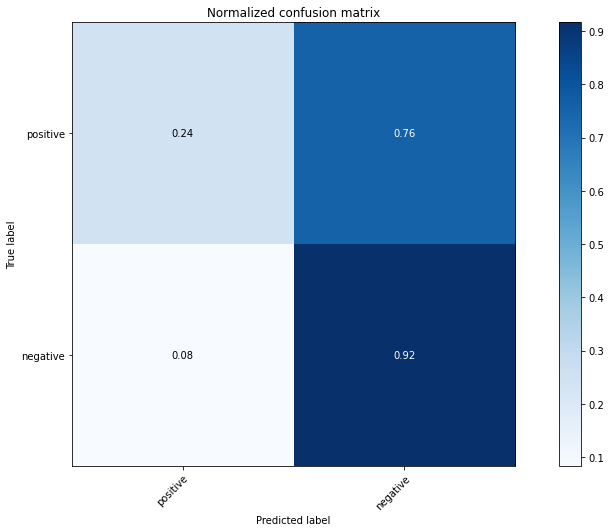

              precision    recall  f1-score   support

    Positive       0.75      0.24      0.37      3119
    Negative       0.55      0.92      0.68      3084

    accuracy                           0.58      6203
   macro avg       0.65      0.58      0.53      6203
weighted avg       0.65      0.58      0.52      6203



In [61]:
import timeit

class_names = ['positive', 'negative']
%time
nb = MultinomialNB()

Multi_NB = Pipeline([('tfidf', vect), ('clf', nb)])
Multi_NB.fit(x_train, y_train)

ynb_pred = Multi_NB.predict(x_val)

print("Accuracy: {:.2f}%".format(accuracy_score(y_val, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_val, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_val, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print(metrics.classification_report(y_val, ynb_pred,
                                            target_names=['Positive', 'Negative']))

#### Random Forest Classifier

Accuracy: 67.52%

F1 Score: 67.52

COnfusion Matrix:
 [[2125  994]
 [1021 2063]]


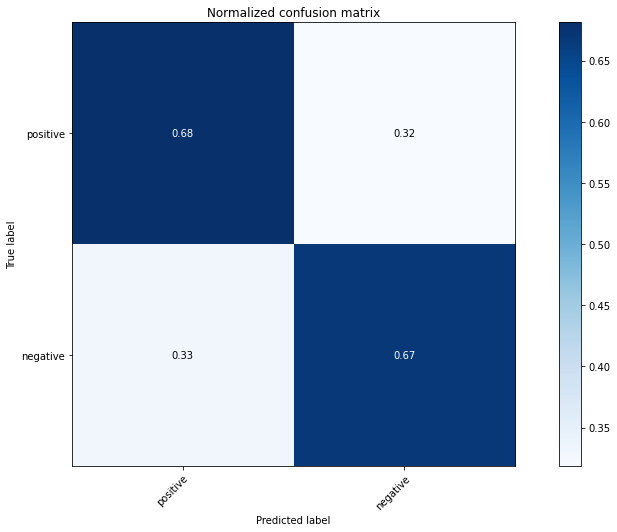

              precision    recall  f1-score   support

    Positive       0.68      0.68      0.68      3119
    Negative       0.67      0.67      0.67      3084

    accuracy                           0.68      6203
   macro avg       0.68      0.68      0.68      6203
weighted avg       0.68      0.68      0.68      6203



In [311]:
rf = RandomForestClassifier(n_estimators=100)

RF = Pipeline([('tfidf', vect), ('clf', rf)])
RF.fit(x_train, y_train)

yrf_pred = RF.predict(x_val)

print("Accuracy: {:.2f}%".format(accuracy_score(y_val, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_val, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_val, yrf_pred))

plot_confusion_matrix(y_val, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print(metrics.classification_report(y_val, yrf_pred,
                                            target_names=['Positive', 'Negative']))

#### Logistic Regression 

Accuracy: 61.73%

F1 Score: 61.73

COnfusion Matrix:
 [[1842 1277]
 [1097 1987]]


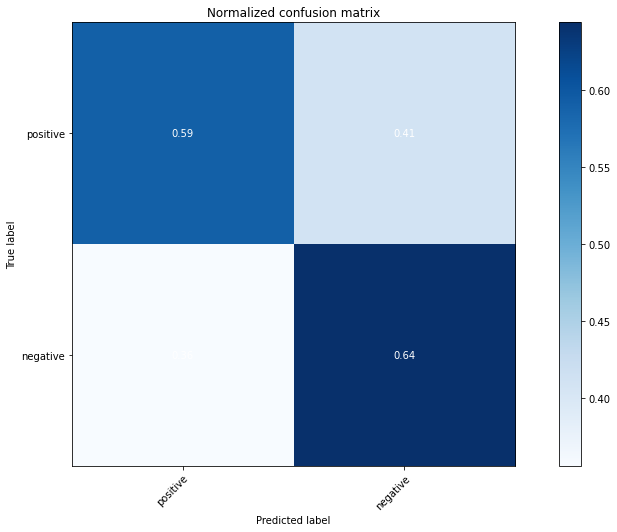

              precision    recall  f1-score   support

    Positive       0.63      0.59      0.61      3119
    Negative       0.61      0.64      0.63      3084

    accuracy                           0.62      6203
   macro avg       0.62      0.62      0.62      6203
weighted avg       0.62      0.62      0.62      6203



In [312]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_val_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_val, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_val, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_val, ylog_pred))

plot_confusion_matrix(y_val, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print(metrics.classification_report(y_val, ylog_pred,
                                            target_names=['Positive', 'Negative']))

#### SVM 

Accuracy: 61.62%

F1 Score: 61.62

COnfusion Matrix:
 [[1856 1263]
 [1118 1966]]


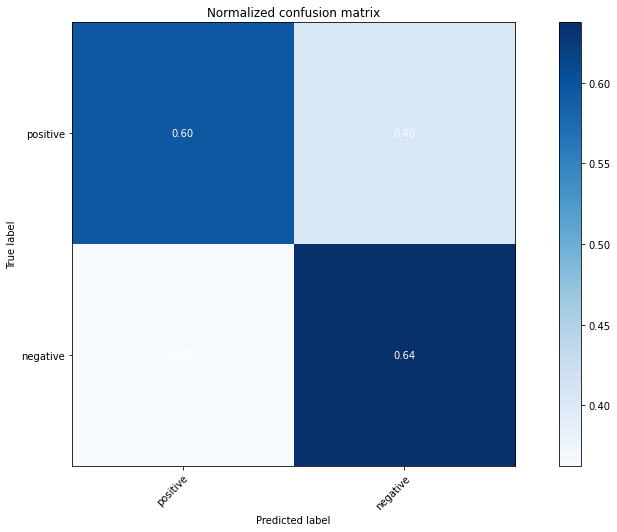

              precision    recall  f1-score   support

    Positive       0.62      0.60      0.61      3119
    Negative       0.61      0.64      0.62      3084

    accuracy                           0.62      6203
   macro avg       0.62      0.62      0.62      6203
weighted avg       0.62      0.62      0.62      6203



In [313]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_val_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_val, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_val, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_val, ysvm_pred))

plot_confusion_matrix(y_val, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print(metrics.classification_report(y_val, ysvm_pred,
                                            target_names=['Positive', 'Negative']))

# Deep Learning

## Method 2: text pre-processing using Word2Vec and LSTM

####Embedding Layer
Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. We can also train the w2v model with our data, however our dataset is quite small and trained word vectors might not be as good as using pretrained w2v.

#####Deep Network
Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words). Patterns could be expressions like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position.

#### Fully Connected Layer
The fully connected layer takes the deep representation from the LSTM and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.
Output Layer
Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.


In [150]:
# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [152]:
# Number of labels: '1', '2'
num_classes = 2

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['positive', 'negative']

In [154]:
def clean_text(data):
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

texts = [' '.join(clean_text(text)) for text in train_dataset.content]

texts_train = [' '.join(clean_text(text)) for text in x_train]
texts_val = [' '.join(clean_text(text)) for text in x_val]



In [237]:
print(texts_val[2])

Great package . The blue ray , regular DVD and digital copy is a great little package giving you the flexibility to watch it where ever ! The movie itself is great like most things from Pixar .


In [156]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_dataset.content)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_val = tokenizer.texts_to_sequences(texts_val)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 68218


In [157]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_val_pad = pad_sequences(sequence_val, maxlen = max_seq_len )

X_val_pad.shape

(6203, 500)

In [176]:
encoding = {
     2 : 1,
     1 : 0,
}

# Integer labels
Y_train = [encoding[x] for x in y_train]
Y_val = [encoding[x] for x in y_val]


In [177]:
Y_train = to_categorical(Y_train, num_classes=2)
Y_val = to_categorical(Y_val, num_classes=2)

Y_train.shape

(24810, 2)

In [162]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [163]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [164]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(68219, 300)

In [165]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 44815
New words found: 23403


In [166]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [169]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional

In [179]:
def LSTM_model(X_train_pad,y_train,X_test_pad, y_test,bidirectional_active):
    # Parameters
    _output_size = 128
    bidirectional = bidirectional_active

    # Embedding Layer, LSTM or biLSTM, Dense, softmax
    model = Sequential()
    model.add(embedd_layer)

    if bidirectional:
        model.add(Bidirectional(layers.LSTM(units=_output_size,
                                  dropout=0.2,
                                  recurrent_dropout=0.2)))
    else:
        model.add(layers.LSTM(units=_output_size,
                    dropout=0.2, 
                    recurrent_dropout=0.2))

    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.summary()

    batch_size = 256
    epochs = 15

    # simple early stopping
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)

    hist = model.fit(X_train_pad, y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[es],
                    validation_data=(X_test_pad,y_test))
    return model, hist

In [180]:
BiLSTM, BiLSTM_hist =LSTM_model(X_train_pad,Y_train,X_val_pad, Y_val, bidirectional_active= True) #Bidirectional

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          20465700  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 20,905,510
Trainable params: 439,810
Non-trainable params: 20,465,700
_________________________________________________________________
Epoch 1/15
97/97 [==============================] - 340s 3s/step - loss: 0.5891 - accuracy: 0.7006 - val_loss: 0.3819 - val_accuracy: 0.8380
Epoch 2/15
97/97 [==============================] - 333s 3s/step - loss: 0.3917 - accuracy: 0.8316 - val_loss: 0.3646 - val_accuracy: 0.8478
Epoch 3/15
97/97 [==============================] - 340s 4s/step - loss: 0.3649 - ac

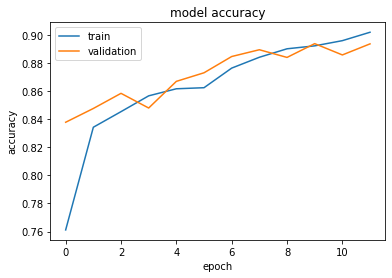

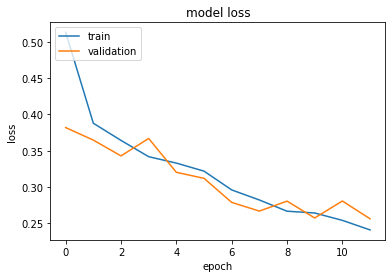

In [181]:
# Accuracy plot
plt.plot(BiLSTM_hist.history['accuracy'])
plt.plot(BiLSTM_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(BiLSTM_hist.history['loss'])
plt.plot(BiLSTM_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [182]:
X_val_pad

array([[    0,     0,     0, ...,   171,    81,     6],
       [    0,     0,     0, ...,   921,    26,   210],
       [    0,     0,     0, ...,   246,    36, 12256],
       ...,
       [    0,     0,     0, ...,    14,    11,    12],
       [    0,     0,     0, ...,    55,   586, 22760],
       [    0,     0,     0, ...,     6,     4,   787]], dtype=int32)

In [235]:
prediction = BiLSTM.predict_classes(X_val_pad)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Bert Model & Bert Pre-processing


In [293]:
!pip install transformers

     |████████████████████████████████| 2.2MB 10.0MB/s 
     |████████████████████████████████| 870kB 50.2MB/s 
     |████████████████████████████████| 3.3MB 37.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=27049b63b3648776c098acec53e4695ae61b820668ed63a0f619934cfd454227
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [294]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

BERT = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [295]:
BERT.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [296]:
review_dataset = pd.read_csv('review_table.csv', engine='python')

In [297]:
def binary_polarity_labelling(value):
  # create a column to label the data as positive or negative base on ratings
  return 1 if value >= 4 else 0

def bert_categorize_data(dataframe):

  #remove rating '3' from the dataframe
  dataframe = dataframe[dataframe['rating'] != 3]

  #creating a new label from ratings
  dataframe['label'] = dataframe['rating'].apply(binary_polarity_labelling)

  dataframe['content'] = dataframe['review_title']+ ".\n " +dataframe['review']

  #extract necessary columns from dataframe
  dataframe = dataframe.loc[:,['product_id', 'generic_product', 'content', 'label']]
  
  #drop empty rows if elements are missing in 'content' column
  dataframe =dataframe.dropna(subset=['content'])

  #drop duplicates from dataframe of elements are missing in 'content' column
  dataframe.drop_duplicates(subset=['content'])

  #resetting index
  dataframe.reset_index(drop=True, inplace=True)
  
  return dataframe


In [298]:
review_dataset = bert_categorize_data(review_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [299]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(review_dataset, test_size=0.2, random_state=1)

train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
train_df.reset_index(drop = True, inplace= True)
val_df.reset_index(drop = True, inplace= True)

In [300]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


In [301]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train_df, val_df, 'content', 'label')

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [302]:
BERT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

Bert_hist = BERT.fit(train_data, epochs=2, validation_data=validation_data, verbose=1)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
def bert_predict(pred_sentences):
  tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = BERT(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  polarity= tf.keras.backend.get_value(tf_predictions)
  polarity = polarity.tolist()
  labels = ['Negative','Positive']
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()
  print(label)
  return polarity[0][1] 


In [ ]:
# creates a HDF5 file 'my_model.h5'
tf.saved_model.save(BERT, '/content')

INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


In [ ]:
review_dataset_new = pd.read_csv('review_table_new.csv', engine='python')

In [ ]:
review_dataset_new

,index,product_id,product,generic_product,uname,rating,review_title,review,date,image,upvotes
0,0,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,SourceIt,2.0,Phone come without charger....Interesting,This item doesn't came with the charger......w...,2021-03-21T00:00:00,NaN,11
1,1,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Galiwango Bryan,5.0,Top Notch,"Fast Delivery,\nSamsung really done a really g...",2021-02-16T00:00:00,NaN,9
2,2,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Aaron Maharaj,5.0,Excellent phone and price combo,"Pros:\nSnapdragon 888,\n8GB RAM,\n128GB,\nBack...",2021-03-24T00:00:00,NaN,4
3,3,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,AD,3.0,Does not worth the money with its standard fea...,The enhancements they have been talking about...,2021-03-31T00:00:00,NaN,2
4,4,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,NessyP83,5.0,Perfect upgrade,Great upgrade. Battery is really good. Photos ...,2021-03-07T00:00:00,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...
11099,11099,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,SomePerson,2.0,Disappointing audio quality,While there are some major pros for this speak...,2019-06-24T00:00:00,NaN,4
11100,11100,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Irving Washington,5.0,Sony SRS-XB12 Speakers,This is my third set of these things.\nFor yea...,2020-11-15T00:00:00,NaN,0
11101,11101,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Don Caruana,5.0,Great sound in a small package!,Absolutely LOVE the sound on this speaker! No ...,2019-08-20T00:00:00,NaN,2
11102,11102,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Twila MK,5.0,Pretty great!,This little guy is pretty great. I recently mo...,2020-07-03T00:00:00,NaN,1


In [ ]:
review_dataset_new = pd.read_csv('review_table_new.csv', engine='python')
review_dataset_new['content'] = review_dataset_new['review_title']+ ".\n " +review_dataset_new['review']
#drop empty rows if elements are missing in 'content' column
review_dataset_new =review_dataset_new.dropna(subset=['content'])

#drop duplicates from dataframe of elements are missing in 'content' column
review_dataset_new.drop_duplicates(subset=['content'])

#resetting index
review_dataset_new.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
review_dataset_new

,index,product_id,product,generic_product,uname,rating,review_title,review,date,image,upvotes,content
0,0,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,SourceIt,2.0,Phone come without charger....Interesting,This item doesn't came with the charger......w...,2021-03-21T00:00:00,NaN,11,Phone come without charger....Interesting.\n T...
1,1,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Galiwango Bryan,5.0,Top Notch,"Fast Delivery,\nSamsung really done a really g...",2021-02-16T00:00:00,NaN,9,"Top Notch.\n Fast Delivery,\nSamsung really do..."
2,2,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Aaron Maharaj,5.0,Excellent phone and price combo,"Pros:\nSnapdragon 888,\n8GB RAM,\n128GB,\nBack...",2021-03-24T00:00:00,NaN,4,Excellent phone and price combo.\n Pros:\nSnap...
3,3,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,AD,3.0,Does not worth the money with its standard fea...,The enhancements they have been talking about...,2021-03-31T00:00:00,NaN,2,Does not worth the money with its standard fea...
4,4,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,NessyP83,5.0,Perfect upgrade,Great upgrade. Battery is really good. Photos ...,2021-03-07T00:00:00,NaN,2,Perfect upgrade.\n Great upgrade. Battery is r...
...,...,...,...,...,...,...,...,...,...,...,...,...
11098,11099,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,SomePerson,2.0,Disappointing audio quality,While there are some major pros for this speak...,2019-06-24T00:00:00,NaN,4,Disappointing audio quality.\n While there are...
11099,11100,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Irving Washington,5.0,Sony SRS-XB12 Speakers,This is my third set of these things.\nFor yea...,2020-11-15T00:00:00,NaN,0,Sony SRS-XB12 Speakers.\n This is my third set...
11100,11101,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Don Caruana,5.0,Great sound in a small package!,Absolutely LOVE the sound on this speaker! No ...,2019-08-20T00:00:00,NaN,2,Great sound in a small package!.\n Absolutely ...
11101,11102,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Twila MK,5.0,Pretty great!,This little guy is pretty great. I recently mo...,2020-07-03T00:00:00,NaN,1,Pretty great!.\n This little guy is pretty gre...


In [ ]:
review_dataset_new['BERT_polarity']  = review_dataset_new['content'].apply(bert_predict)

In [ ]:
review_dataset_new.content[0]

"Phone come without charger....Interesting.\n This item doesn't came with the charger......which suppose to come.....now i need to buy it seperately"

In [ ]:
review_dataset_new.to_csv("bert_new.csv", index= False)

Generate CSV

In [270]:
bert_dataset = pd.read_csv('bert.csv', engine='python')

In [64]:
review_dataset_new = pd.read_csv('review_table_new.csv', engine='python')
review_dataset_new['content'] = review_dataset_new['review_title']+ ".\n " +review_dataset_new['review']
#drop empty rows if elements are missing in 'content' column
review_dataset_new =review_dataset_new.dropna(subset=['content'])

#drop duplicates from dataframe of elements are missing in 'content' column
review_dataset_new.drop_duplicates(subset=['content'])

#resetting index
review_dataset_new.reset_index(drop=True, inplace=True)

### Using Vader Sentiment 

In [62]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 6.5MB/s 


In [66]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def normalise_vader(score):
  score = (score+1)/2
  return score

sid = SentimentIntensityAnalyzer()

review_dataset_new['vader_polarity'] = review_dataset_new['content'].progress_apply(lambda content: sid.polarity_scores(content))
review_dataset_new['vader_polarity']  = review_dataset_new['vader_polarity'].apply(lambda score_dict: score_dict['compound'])
review_dataset_new['vader_polarity']  = review_dataset_new['vader_polarity'].apply(normalise_vader)

In [275]:
review_dataset_new

,index,product_id,product,generic_product,uname,rating,review_title,review,date,image,upvotes,content,vader_polarity
0,0,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,SourceIt,2.0,Phone come without charger....Interesting,This item doesn't came with the charger......w...,2021-03-21T00:00:00,NaN,11,Phone come without charger....Interesting.\n T...,0.50000
1,1,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Galiwango Bryan,5.0,Top Notch,"Fast Delivery,\nSamsung really done a really g...",2021-02-16T00:00:00,NaN,9,"Top Notch.\n Fast Delivery,\nSamsung really do...",0.97890
2,2,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Aaron Maharaj,5.0,Excellent phone and price combo,"Pros:\nSnapdragon 888,\n8GB RAM,\n128GB,\nBack...",2021-03-24T00:00:00,NaN,4,Excellent phone and price combo.\n Pros:\nSnap...,0.80815
3,3,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,AD,3.0,Does not worth the money with its standard fea...,The enhancements they have been talking about...,2021-03-31T00:00:00,NaN,2,Does not worth the money with its standard fea...,0.80190
4,4,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,NessyP83,5.0,Perfect upgrade,Great upgrade. Battery is really good. Photos ...,2021-03-07T00:00:00,NaN,2,Perfect upgrade.\n Great upgrade. Battery is r...,0.98910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098,11099,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,SomePerson,2.0,Disappointing audio quality,While there are some major pros for this speak...,2019-06-24T00:00:00,NaN,4,Disappointing audio quality.\n While there are...,0.19200
11099,11100,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Irving Washington,5.0,Sony SRS-XB12 Speakers,This is my third set of these things.\nFor yea...,2020-11-15T00:00:00,NaN,0,Sony SRS-XB12 Speakers.\n This is my third set...,0.97075
11100,11101,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Don Caruana,5.0,Great sound in a small package!,Absolutely LOVE the sound on this speaker! No ...,2019-08-20T00:00:00,NaN,2,Great sound in a small package!.\n Absolutely ...,0.93150
11101,11102,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Twila MK,5.0,Pretty great!,This little guy is pretty great. I recently mo...,2020-07-03T00:00:00,NaN,1,Pretty great!.\n This little guy is pretty gre...,0.99620


In [276]:
texts_new = [' '.join(clean_text(text)) for text in review_dataset_new.content.to_list()]
sequence_new = tokenizer.texts_to_sequences(texts_new)
X_new_pad = pad_sequences(sequence_new, maxlen = max_seq_len )
prediction = BiLSTM.predict_proba(X_new_pad)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [277]:
len(prediction.tolist())

11103

In [278]:
bilstm = []
for i in range(len(prediction.tolist())):
  bilstm.append(prediction.tolist()[i][1])

In [279]:
from pandas import DataFrame
bilstm_df = DataFrame(bilstm,columns=['BiLSTM_polarity'])

In [280]:
review_dataset_new['BiLSTM_polarity'] = bilstm_df['BiLSTM_polarity']

In [282]:
review_dataset_new

,index,product_id,product,generic_product,uname,rating,review_title,review,date,image,upvotes,content,vader_polarity,BiLSTM_polarity
0,0,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,SourceIt,2.0,Phone come without charger....Interesting,This item doesn't came with the charger......w...,2021-03-21T00:00:00,NaN,11,Phone come without charger....Interesting.\n T...,0.50000,0.674336
1,1,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Galiwango Bryan,5.0,Top Notch,"Fast Delivery,\nSamsung really done a really g...",2021-02-16T00:00:00,NaN,9,"Top Notch.\n Fast Delivery,\nSamsung really do...",0.97890,0.962041
2,2,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Aaron Maharaj,5.0,Excellent phone and price combo,"Pros:\nSnapdragon 888,\n8GB RAM,\n128GB,\nBack...",2021-03-24T00:00:00,NaN,4,Excellent phone and price combo.\n Pros:\nSnap...,0.80815,0.901285
3,3,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,AD,3.0,Does not worth the money with its standard fea...,The enhancements they have been talking about...,2021-03-31T00:00:00,NaN,2,Does not worth the money with its standard fea...,0.80190,0.169424
4,4,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,NessyP83,5.0,Perfect upgrade,Great upgrade. Battery is really good. Photos ...,2021-03-07T00:00:00,NaN,2,Perfect upgrade.\n Great upgrade. Battery is r...,0.98910,0.971558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098,11099,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,SomePerson,2.0,Disappointing audio quality,While there are some major pros for this speak...,2019-06-24T00:00:00,NaN,4,Disappointing audio quality.\n While there are...,0.19200,0.104203
11099,11100,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Irving Washington,5.0,Sony SRS-XB12 Speakers,This is my third set of these things.\nFor yea...,2020-11-15T00:00:00,NaN,0,Sony SRS-XB12 Speakers.\n This is my third set...,0.97075,0.791141
11100,11101,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Don Caruana,5.0,Great sound in a small package!,Absolutely LOVE the sound on this speaker! No ...,2019-08-20T00:00:00,NaN,2,Great sound in a small package!.\n Absolutely ...,0.93150,0.805571
11101,11102,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Twila MK,5.0,Pretty great!,This little guy is pretty great. I recently mo...,2020-07-03T00:00:00,NaN,1,Pretty great!.\n This little guy is pretty gre...,0.99620,0.956364


In [283]:
bert_dataset = pd.read_csv('bert_new.csv', engine='python')
review_dataset_new['BERT_polarity'] = bert_dataset['BERT_polarity']
review_dataset_new

,index,product_id,product,generic_product,uname,rating,review_title,review,date,image,upvotes,content,vader_polarity,BiLSTM_polarity,BERT_polarity
0,0,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,SourceIt,2.0,Phone come without charger....Interesting,This item doesn't came with the charger......w...,2021-03-21T00:00:00,NaN,11,Phone come without charger....Interesting.\n T...,0.50000,0.674336,0.993369
1,1,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Galiwango Bryan,5.0,Top Notch,"Fast Delivery,\nSamsung really done a really g...",2021-02-16T00:00:00,NaN,9,"Top Notch.\n Fast Delivery,\nSamsung really do...",0.97890,0.962041,0.999109
2,2,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,Aaron Maharaj,5.0,Excellent phone and price combo,"Pros:\nSnapdragon 888,\n8GB RAM,\n128GB,\nBack...",2021-03-24T00:00:00,NaN,4,Excellent phone and price combo.\n Pros:\nSnap...,0.80815,0.901285,0.999169
3,3,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,AD,3.0,Does not worth the money with its standard fea...,The enhancements they have been talking about...,2021-03-31T00:00:00,NaN,2,Does not worth the money with its standard fea...,0.80190,0.169424,0.001593
4,4,B08N2FRMPN,Samsung Electronics Samsung Galaxy S21 5G | Fa...,Smartphone,NessyP83,5.0,Perfect upgrade,Great upgrade. Battery is really good. Photos ...,2021-03-07T00:00:00,NaN,2,Perfect upgrade.\n Great upgrade. Battery is r...,0.98910,0.971558,0.999334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098,11099,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,SomePerson,2.0,Disappointing audio quality,While there are some major pros for this speak...,2019-06-24T00:00:00,NaN,4,Disappointing audio quality.\n While there are...,0.19200,0.104203,0.001645
11099,11100,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Irving Washington,5.0,Sony SRS-XB12 Speakers,This is my third set of these things.\nFor yea...,2020-11-15T00:00:00,NaN,0,Sony SRS-XB12 Speakers.\n This is my third set...,0.97075,0.791141,0.996306
11100,11101,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Don Caruana,5.0,Great sound in a small package!,Absolutely LOVE the sound on this speaker! No ...,2019-08-20T00:00:00,NaN,2,Great sound in a small package!.\n Absolutely ...,0.93150,0.805571,0.998956
11101,11102,B07P85CDHG,Sony SRS-XB12 Mini Bluetooth Speaker Loud Extr...,Speaker,Twila MK,5.0,Pretty great!,This little guy is pretty great. I recently mo...,2020-07-03T00:00:00,NaN,1,Pretty great!.\n This little guy is pretty gre...,0.99620,0.956364,0.999163


In [284]:
review_dataset_new.to_csv("review_table_edited.csv", index= False)

In [197]:
# creates a HDF5 file 'my_model.h5'
BiLSTM.save('BiLSTM_Word2Vec.h5')

In [247]:
def bilstm_polarity(message):
  seq = tokenizer.texts_to_sequences(message)
  padded = pad_sequences(seq, maxlen=max_seq_len)
  pred = model.predict(padded)
  classes = label[np.argmax(pred)]
  prediction = BiLSTM.predict_proba(padded)
  polarity = (prediction[0])
  return polarity

In [248]:
bilstm_polarity(message)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([0.34039044, 0.76412266], dtype=float32)